# Data preparation

In [9]:
from pathlib import Path
import pickle
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

## 1. Load raw data

In [10]:
data_df=pd.read_csv('../data/raw/workout_fitness_tracker_data.csv')

## 2. Select features

In [11]:
data_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   User ID                   10000 non-null  int64  
 1   Age                       10000 non-null  int64  
 2   Gender                    10000 non-null  object 
 3   Height (cm)               10000 non-null  int64  
 4   Weight (kg)               10000 non-null  int64  
 5   Workout Type              10000 non-null  object 
 6   Workout Duration (mins)   10000 non-null  int64  
 7   Calories Burned           10000 non-null  int64  
 8   Heart Rate (bpm)          10000 non-null  int64  
 9   Steps Taken               10000 non-null  int64  
 10  Distance (km)             10000 non-null  float64
 11  Workout Intensity         10000 non-null  object 
 12  Sleep Hours               10000 non-null  float64
 13  Water Intake (liters)     10000 non-null  float64
 14  Daily C

Given some self-report biometrics from the user we will build two models that do the following depending on user input:

1. Take workout duration and predict calorie burn for each workout type (i.e. 'I am going to work out for X minutes, how many calories will I burn?').
2. Take calorie burn and predict duration for each workout type (i.e., 'I want to burn X calories, how long do I need to work out for?').

Both models will share a set of input 'biometric' features. These must be things the user is likely to know about themselves. People probably know their weight and age, but probably don't know their VO2 max.

The models will differ in one of their input features and their output:

1. `calorie_model` needs to take workout duration + biometrics as input features and predict calories burned.
2. `time_model` needs to take calories burned + biometrics as input features and predict workout duration. 

We will use dictionaries to keep everything organized

In [5]:
biometric_features=[
    'Age',
    'Height (cm)',
    'Weight (kg)',
    'Sleep Hours',
    'Resting Heart Rate (bpm)',
]

input_features={
    'calorie_model': 'Workout Duration (mins)',
    'time_model': 'Calories Burned'
}

output_features={
    'calorie_model': 'Calories Burned',
    'time_model': 'Workout Duration (mins)'
}

## 3. Encode categorical features

In [6]:
categorical_features=['Workout Type', 'Gender', 'Workout Intensity', 'Mood Before Workout', 'Mood After Workout']

# Your code here... I recommend sklearn's OrdinalEncoder to start with because it will let us keep the 
# number/names of features constant. We can experiment with improving encoding later if we have time.

In [7]:
print([df[categorical_features].nunique() for df in [data_df]])

[Workout Type           6
Gender                 3
Workout Intensity      3
Mood Before Workout    4
Mood After Workout     3
dtype: int64]


In [16]:
from sklearn.preprocessing import OrdinalEncoder

df_encoded = data_df.copy()

# Fit and transform only the categorical features
encoder = OrdinalEncoder()
encoded_values = encoder.fit_transform(data_df[categorical_features])

# Convert encoded values to int and assign back
df_encoded[categorical_features] = encoded_values.astype(int)

# Preview
print(df_encoded[categorical_features].head())

   Workout Type  Gender  Workout Intensity  Mood Before Workout  \
0             1       1                  0                    3   
1             0       2                  0                    0   
2             2       0                  0                    0   
3             1       1                  2                    1   
4             4       2                  2                    2   

   Mood After Workout  
0                   1  
1                   0  
2                   1  
3                   2  
4                   0  


In [22]:
df_encoded = df_encoded.drop(columns=['Water Intake (liters)', 'VO2 Max', 'Body Fat (%)'], axis=1)

In [23]:
df_encoded

,User ID,Age,Gender,Height (cm),Weight (kg),Workout Type,Workout Duration (mins),Calories Burned,Heart Rate (bpm),Steps Taken,Distance (km),Workout Intensity,Sleep Hours,Daily Calories Intake,Resting Heart Rate (bpm),Mood Before Workout,Mood After Workout
0,1,39,1,175,99,1,79,384,112,8850,14.44,0,8.2,3195,61,3,1
1,2,36,2,157,112,0,73,612,168,2821,1.10,0,8.6,2541,73,0,0
2,3,25,0,180,66,2,27,540,133,18898,7.28,0,9.8,3362,80,0,1
3,4,56,1,154,89,1,39,672,118,14102,6.55,2,5.8,2071,65,1,2
4,5,53,2,194,59,4,56,410,170,16518,3.17,2,7.3,3298,59,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,20,2,173,59,5,95,230,160,1330,12.83,2,10.0,3718,56,1,2
9996,9997,29,0,171,71,2,83,539,170,3236,9.74,1,9.4,2752,72,3,1
9997,9998,47,1,183,75,3,89,886,114,10532,14.51,2,8.1,1572,73,1,1
9998,9999,52,1,170,97,2,28,447,102,13690,1.43,1,7.3,2172,84,2,1


In [44]:
df_encoded['Calories Burned'].describe()
# Split the data into training and testing sets

count    10000.000000
mean       552.100800
std        260.629908
min        100.000000
25%        325.000000
50%        554.000000
75%        776.000000
max        999.000000
Name: Calories Burned, dtype: float64

## 4. Train-test split

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import randint, uniform
import numpy as np

# 1. Set up features and target
target_col = 'Calories Burned'
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 3. Define base model
model = GradientBoostingRegressor(random_state=42)

# 4. Define hyperparameter search space
param_dist = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 5. Search setup
scorer = make_scorer(mean_squared_error, greater_is_better=False)
search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    scoring=scorer,
    n_iter=50,        # Fewer iterations = faster
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 6. Run the search
search.fit(X_train, y_train)

print("Best parameters found: ", search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.05}


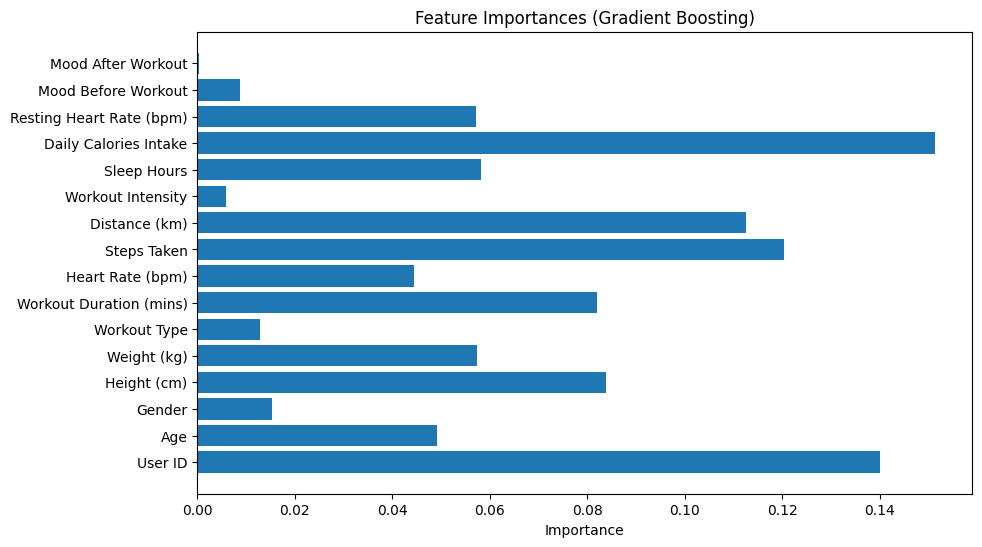

In [45]:
import matplotlib.pyplot as plt

feature_importances = best_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel("Importance")
plt.title("Feature Importances (Gradient Boosting)")
plt.show()

In [46]:
df_dropped = df_encoded.drop(columns=['Gender', 'Workout Type', 'Workout Intensity', 'Mood Before Workout', 'Mood After Workout'], axis=1)

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import randint, uniform
import numpy as np

# 1. Set up features and target
target_col = 'Calories Burned'
X = df_dropped.drop(columns=[target_col])
y = df_dropped[target_col]

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 3. Define base model
model = GradientBoostingRegressor(random_state=42)

# 4. Define hyperparameter search space
param_dist = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 5. Search setup
scorer = make_scorer(mean_squared_error, greater_is_better=False)
search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    scoring=scorer,
    n_iter=500,        
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 6. Run the search
search.fit(X_train, y_train)

print("Best parameters found: ", search.best_params_)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 64 is smaller than n_iter=500. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.05}


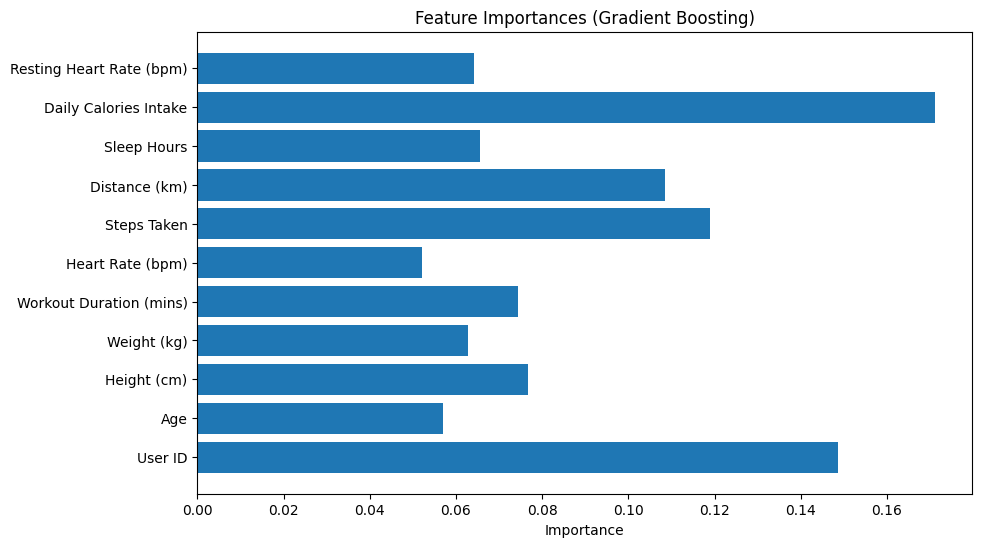

In [52]:
import matplotlib.pyplot as plt

feature_importances = best_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel("Importance")
plt.title("Feature Importances (Gradient Boosting)")
plt.show()

In [53]:
df_dropped2 = df_encoded.drop(columns=['User ID', 'Distance (km)'])

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import randint, uniform
import numpy as np

# 1. Set up features and target
target_col = 'Calories Burned'
X = df_dropped2.drop(columns=[target_col])
y = df_dropped2[target_col]

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 3. Define base model
model = GradientBoostingRegressor(random_state=42)

# 4. Define hyperparameter search space
param_dist = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 5. Search setup
scorer = make_scorer(mean_squared_error, greater_is_better=False)
search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    scoring=scorer,
    n_iter=500,        
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 6. Run the search
search.fit(X_train, y_train)

print("Best parameters found: ", search.best_params_)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 64 is smaller than n_iter=500. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found:  {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.05}


In [55]:
from sklearn.metrics import r2_score

# Retrieve best model
best_model = search.best_estimator_

# Predict and evaluate
y_pred = best_model.predict(X_test)

print("Best Hyperparameters:", search.best_params_)
print("Test Set Performance")
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.05}
Test Set Performance
R²: -0.00825558633585688
RMSE: 263.1068639231969


In [56]:
assert len(X_train) == len(y_train), "Testing train length"
assert len(X_test) == len(y_test), "Testing test length"

In [57]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test)

print("Linear Regression R²:", r2_score(y_test, y_lr_pred))

Linear Regression R²: -0.005194620716218568


In [58]:
correlations = df_encoded.corr(numeric_only=True)['Calories Burned'].sort_values(ascending=False)
print(correlations)

Calories Burned             1.000000
Daily Calories Intake       0.010564
Distance (km)               0.009488
Age                         0.009123
Workout Type                0.006961
Gender                      0.006921
Resting Heart Rate (bpm)    0.005639
Steps Taken                 0.001744
Sleep Hours                -0.000041
Mood After Workout         -0.000172
Mood Before Workout        -0.001069
Height (cm)                -0.002398
Heart Rate (bpm)           -0.006594
Workout Duration (mins)    -0.006739
User ID                    -0.010789
Workout Intensity          -0.013890
Weight (kg)                -0.023416
Name: Calories Burned, dtype: float64


## 5. Save assets

In [ ]:
# Feature information
with open('../data/biometric_features.pkl', 'wb') as output_file:
    pickle.dump(biometric_features, output_file)

with open('../data/input_features.pkl', 'wb') as output_file:
    pickle.dump(input_features, output_file)

with open('../data/output_features.pkl', 'wb') as output_file:
    pickle.dump(output_features, output_file)

with open('../data/categorical_features.pkl', 'wb') as output_file:
    pickle.dump(categorical_features, output_file)

# Data
Path('../data/processed').mkdir(exist_ok=True)

with open('../data/processed/all.pkl', 'wb') as output_file:
    pickle.dump(data_df, output_file)

with open('../data/processed/train.pkl', 'wb') as output_file:
    pickle.dump(train_df, output_file)

with open('../data/processed/test.pkl', 'wb') as output_file:
    pickle.dump(test_df, output_file)